# Pennycook 2018 - light reanalysis

Pennycook, G., & Rand, D. G. (2018). Lazy, not biased: Susceptibility to partisan fake news is better explained by lack of reasoning than by motivated reasoning. Cognition.
https://www.sciencedirect.com/science/article/pii/S001002771830163X

Related blog from Dan Kahan
http://www.culturalcognition.net/blog/2018/10/25/who-falls-for-fake-news-apparently-no-one.html

Raw data available at:

https://osf.io/f5dgh/

In [12]:
#import libraries and raw data
import pandas as pd #dataframes
import numpy as np #number functions
import matplotlib.pyplot as plt #plotting
import seaborn as sns #fancy plotting
from scipy.optimize import curve_fit #for regressions

%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 12] #make default image size bigger
import warnings; warnings.simplefilter('ignore')

# Study 1 data

In [1]:
#import the data that I already downloaded from OSF
df1=pd.read_csv('Pennycook & Rand (Study 1).csv')

In [2]:
print("We have " +str(len(df1)) + " rows of data (participants?)")

We have 802 rows of data (participants?)


Text(0,0.5,'Frequency')

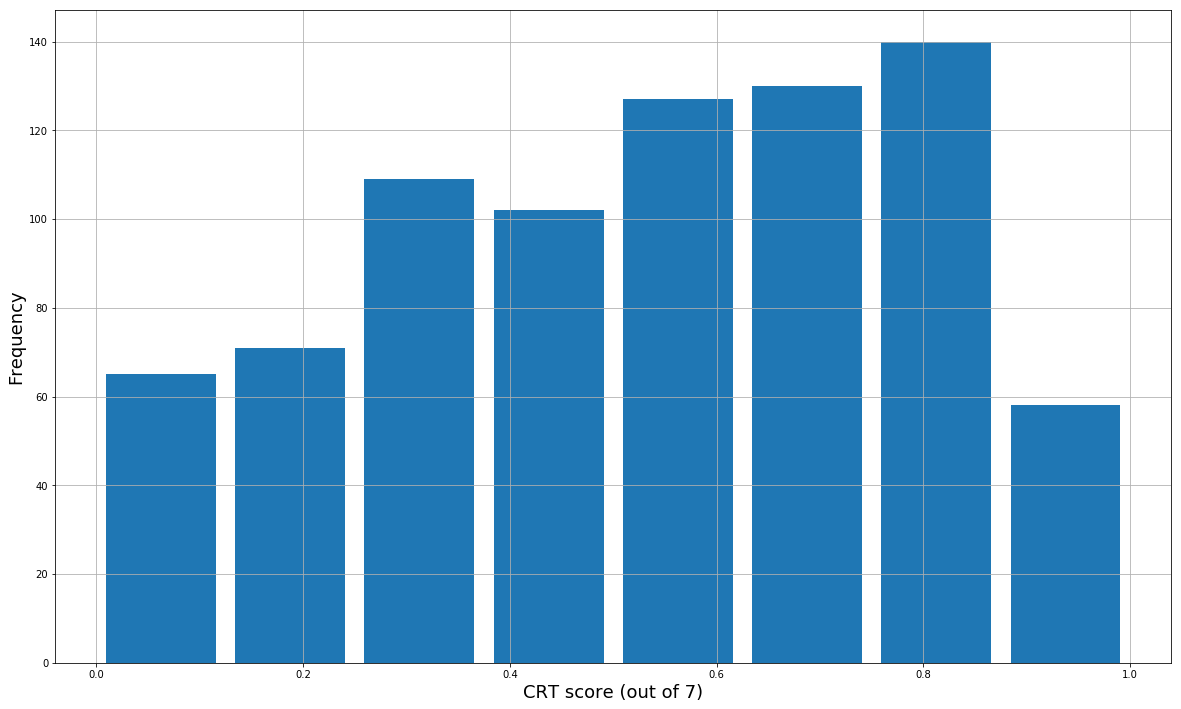

In [3]:
# CRT scores are well distributed

df1['CRT'].hist(bins=8, rwidth=0.85)
plt.xlabel('CRT score (out of 7)',fontsize=18)

plt.ylabel('Frequency',fontsize=18)

# Who believes fake news?

Dan says here that the study is invalid because nobody believed fake news.
http://www.culturalcognition.net/blog/2018/10/25/who-falls-for-fake-news-apparently-no-one.html

Let's plot the distribution of number of fake news stories which were rated as "accurate"



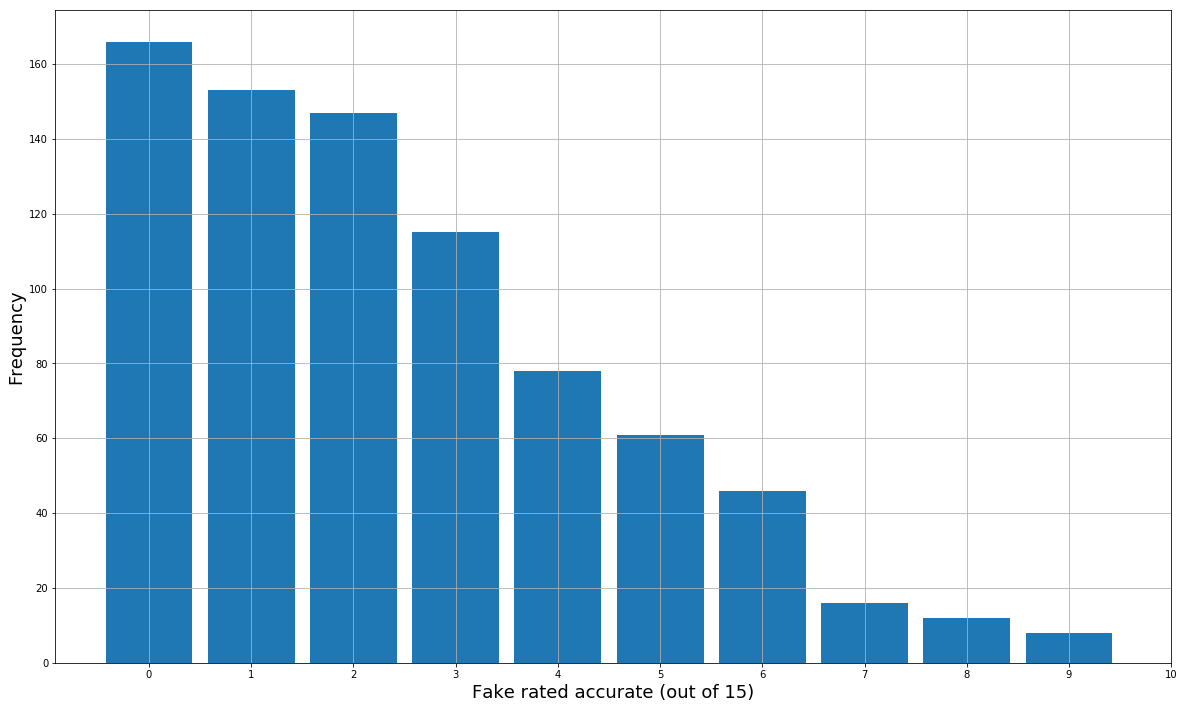

In [5]:
# Fake news stories are rated as accurate or inaccurate

# Let's make a histogram of the number of fake stories rated as accurate across all participants

#these are the variable names for 15 fake news stories

fakes=['Fake1_Accurate','Fake2_Accurate','Fake3_Accurate','Fake4_Accurate','Fake5_Accurate',
       'Fake6_Accurate','Fake7_Accurate','Fake8_Accurate','Fake9_Accurate','Fake10_Accurate',
       'Fake11_Accurate','Fake12_Accurate','Fake13_Accurate','Fake14_Accurate','Fake15_Accurate']

df1[fakes].sum(axis=1).hist(rwidth=0.85)
plt.xlabel('Fake rated accurate (out of 15)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(np.arange(0.5,11,1),[str(a) for a in range(11)]) #make it clear which each column represents

# Lazy not Biased? Or Lazy and Biased?

Let's look at how surceptibility to fake news interacts with cognitive reflection

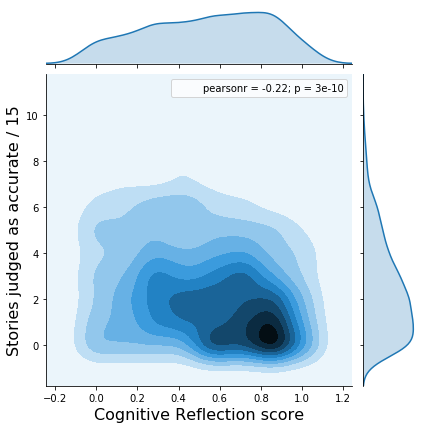

In [6]:
#Let's do a simple correlation first

#Because there is a large sample and a limited number of values on both the x and y axis,
#it is better to plot a heatmap rather than a scatterplot

ax = sns.jointplot(df1['CRT'], df1[fakes].sum(axis=1), kind="kde")
ax.set_axis_labels('Cognitive Reflection score','Stories judged as accurate / 15', fontsize=16)



However this analysis doesn't accout for bias (i.e. each participant's willingness to rate stories as accurate generally), nor for the effect of partisan bias. The correct analysis is from Signal Detection Theory, where we calculate a sensitivity measure for each participant - providing a direct measure of their ability to discriminate fake from real news. P&B did this, but their measure is 0-centered, so you cannot see if participants are accurate at all, so I prefer to calculate d' (the traditional SDT measure).

In [7]:
# CALCULATE D PRIME FOR EACH PARTICIPANT, FOR ITEMS DIVIDED BY THEIR BIAS

#fake items, by partisan bias
CFakes=df1[['Fake1_2','Fake2_2','Fake3_2','Fake4_2','Fake5_2']].apply(pd.to_numeric,errors='coerce')
LFakes=df1[['Fake6_2','Fake7_2','Fake8_2','Fake9_2','Fake10_2']].apply(pd.to_numeric,errors='coerce')
NFakes=df1[['Fake11_2','Fake12_2','Fake13_2','Fake14_2','Fake15_2']].apply(pd.to_numeric,errors='coerce')
#real items, by partisan bias
CReals=df1[['Real1_2','Real2_2','Real3_2','Real4_2','Real5_2']].apply(pd.to_numeric,errors='coerce')
LReals=df1[['Real6_2','Real7_2','Real8_2','Real9_2','Real10_2']].apply(pd.to_numeric,errors='coerce')
NReals=df1[['Real11_2','Real12_2','Real13_2','Real14_2','Real15_2']].apply(pd.to_numeric,errors='coerce')

#calculate proportion of False Alarms (fakes rated as accurate)
df1['CFalseAlarms']=(CFakes>2).sum(axis=1)/5
df1['LFalseAlarms']=(LFakes>2).sum(axis=1)/5
df1['NFalseAlarms']=(NFakes>2).sum(axis=1)/5

#calculate proportion of hits (real stories rated as accurate)
df1['CHits']=(CReals>2).sum(axis=1)/5
df1['LHits']=(LReals>2).sum(axis=1)/5
df1['NHits']=(NReals>2).sum(axis=1)/5

smallval=0.01 #correction for floor or ceiling proportions


'''
Functions for calculatin d prime (three congruency conditions, so three functions)

#there's a better way to do this, but i'm too tired to figure it out
'''
def dprimeCfunc(row):
    from scipy.stats import norm
    if row['CHits']==1:
        hits=1-smallval
    elif row['CHits']==0:
        hits=0+smallval
    else:
        hits=row['CHits']
    if row['CFalseAlarms']==0:
        FAs=0+smallval
    elif row['CFalseAlarms']==1:
        FAs=1-smallval
    else:
        FAs=row['CFalseAlarms']
    return norm.ppf(hits)-norm.ppf(FAs)
    
def dprimeLfunc(row):
    from scipy.stats import norm
    if row['LHits']==1:
        hits=1-smallval
    elif row['LHits']==0:
        hits=0+smallval
    else:
        hits=row['LHits']
    if row['LFalseAlarms']==0:
        FAs=0+smallval
    elif row['LFalseAlarms']==1:
        FAs=1-smallval
    else:
        FAs=row['LFalseAlarms']
    return norm.ppf(hits)-norm.ppf(FAs)

def dprimeNfunc(row):
    from scipy.stats import norm
    if row['NHits']==1:
        hits=1-smallval
    elif row['NHits']==0:
        hits=0+smallval
    else:
        hits=row['NHits']
    if row['NFalseAlarms']==0:
        FAs=0+smallval
    elif row['NFalseAlarms']==1:
        FAs=1-smallval
    else:
        FAs=row['NFalseAlarms']
    return norm.ppf(hits)-norm.ppf(FAs)

#calculate d prime scores
df1['dprimeC']=df1.apply(dprimeCfunc,axis=1)
df1['dprimeL']=df1.apply(dprimeLfunc,axis=1)
df1['dprimeN']=df1.apply(dprimeNfunc,axis=1)

In [8]:
#re-code according to participant partisan bias - Dems looking at C news | Reps looking at L news = congruent, 
df1['cong_dprime']=df1[(df1['ClintonTrump']=='1')]['dprimeC'].append(df1[(df1['ClintonTrump']=='2')]['dprimeL'])
df1['incong_dprime']=df1[(df1['ClintonTrump']=='1')]['dprimeL'].append(df1[(df1['ClintonTrump']=='2')]['dprimeC'])

#highly correlated with discernment scores, e.g.
np.corrcoef(df1['dprimeN'],df1['N_Discernment'])


array([[1.        , 0.81023616],
       [0.81023616, 1.        ]])

In [10]:
#We should confirm this relationship with a regression, as P&R did.
#However, I note that the pairwise correlations survive the heirarchicl multimple regression models they build,
#Suggesting that there AREN'T subgroup interactions by age, sex, etc and presenting simple regressions won't be too misleading

'''
trim and export data for regression modelling
'''

#df_wide=df1[['cong_discernment','incong_discernment','N_Discernment','CRT']]
df_wide=df1[['cong_dprime','incong_dprime','dprimeN','CRT']]

df_wide.columns=['C','I','N','CRT'] #rename columns
df_wide.to_csv('dprimedata_wide.csv')
df_wide=df_wide.dropna()


Text(0.5,1,'Study 1')

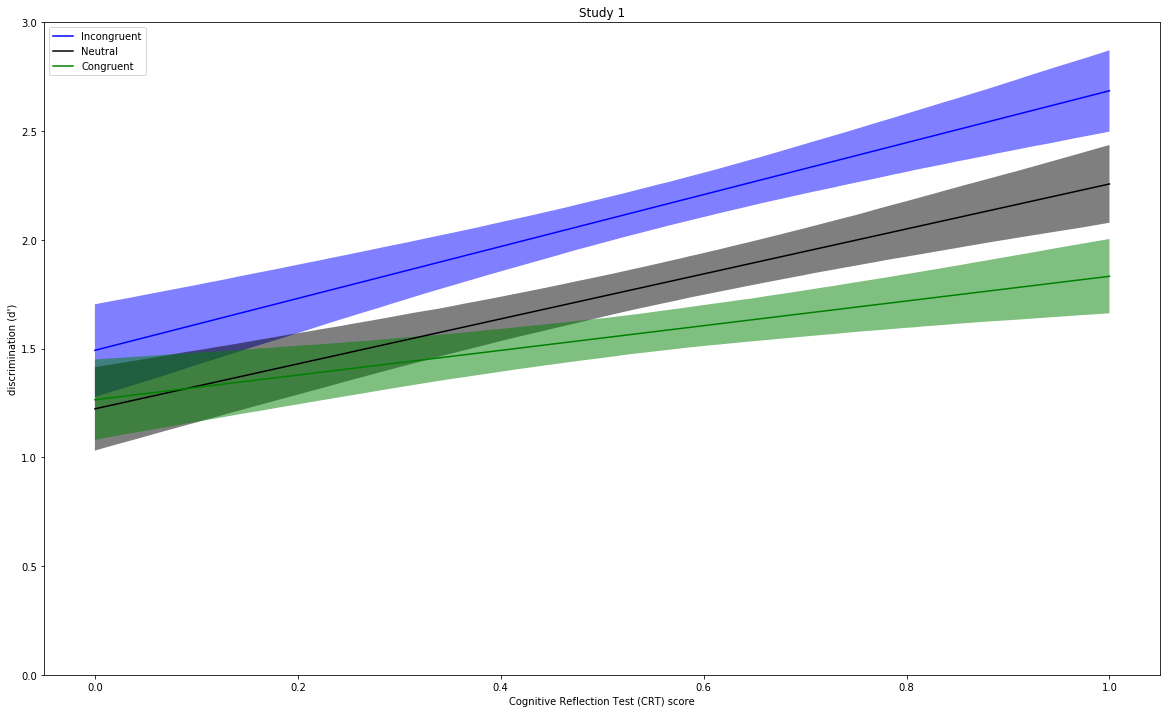

In [16]:
# make some simple regressions
# cribbing from here https://stats.stackexchange.com/questions/256050/linear-regression-from-parameters-with-standard-error-to-prediction-interval


f = lambda x, *p: np.polyval(p, x) #our underlying model is a general polynomial (although we use 1st oder only)

plt.clf()

#loop through three conditions
for cond,condlabel,colour in zip(['I','N','C'],['Incongruent','Neutral','Congruent'],['blue','black','green']):

    x = df_wide['CRT']
    y = df_wide[cond]
    
    p, cov = curve_fit(f, x, y, [1, 1]) #first order fit = linear regression

    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000) #assume that the fit (p, cov) represents a normal distribution and sample from it
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0) # selecting the lower and upper 2.5% quantiles:
    upper = np.percentile(ysample, 97.5, axis=0)

    # regression estimate line
    y_fit = np.poly1d(p)(xi)
    # same as 
    # y_fit2 = xi*p[0]+p[1]
    # plot
    
    #plt.plot(x, y, 'bo') #don't plot individual points
    plt.plot(xi, y_fit, '-',color=colour,label=condlabel)
    plt.fill_between(xi, lower, upper, facecolor=colour, alpha=0.5)


plt.legend(loc=2)
plt.ylim([0,3])
plt.xlabel('Cognitive Reflection Test (CRT) score')
plt.ylabel('discrimination (d\')')
plt.title('Study 1')

# Study 2

In [22]:
df2=pd.read_csv('Pennycook & Rand (Study 2).csv')
#df2['CRT_ACC'] #nb crt variable has a different name

([<matplotlib.axis.XTick at 0x7f7fd8188b70>,
 <a list of 13 Text xticklabel objects>)

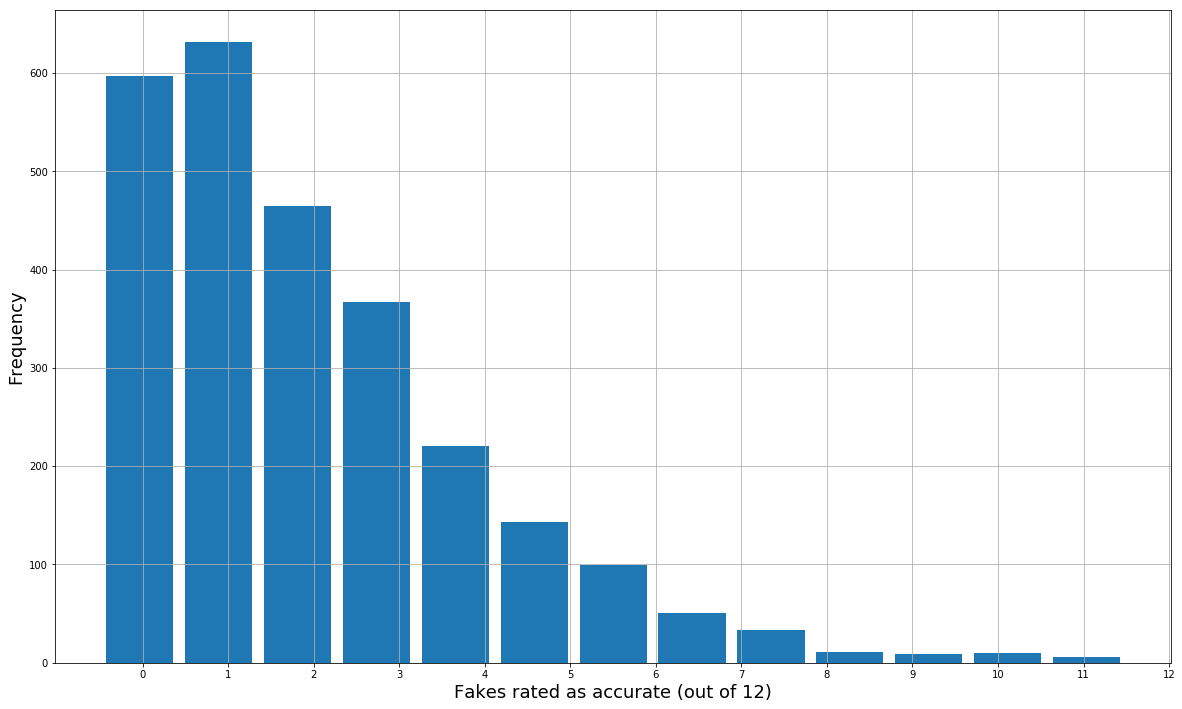

In [23]:
# Distribution of fake stories rated as accurate
fakes=['Fake'+str(n+1)+'_2' for n in range(12)]
reals=['Real'+str(n+1)+'_2' for n in range(12)]

for f in fakes:
    df2[f]=pd.to_numeric(df2[f],errors='coerce')

for f in reals:
    df2[f]=pd.to_numeric(df2[f],errors='coerce')
    
df2['ClintonTrump']=df2['ClintonTrump'].astype(str)


df2['fakes_ac1_to_6']=(df2[fakes[:6]]>2).sum(axis=1)/6
df2['fakes_ac7_to_12']=(df2[fakes[6:]]>2).sum(axis=1)/6
df2['reals_ac1_to_6']=(df2[reals[:6]]>2).sum(axis=1)/6
df2['reals_ac7_to_12']=(df2[reals[6:]]>2).sum(axis=1)/6

# distribution of fakes rated as accurate
plt.clf()
(df2[fakes]>2).sum(axis=1).hist(bins=13, rwidth=0.85)
plt.xlabel('Fakes rated as accurate (out of 12)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(np.arange(0.5,13,1),[str(a) for a in range(13)])




In [24]:
# do regressions again

# need to check this coding - since it makes assumption that C news item are numerically first
def congsort_fakes(row):
    if row['ClintonTrump']=='1':
        return row['fakes_ac1_to_6']
    elif row['ClintonTrump']=='2':
        return row['fakes_ac7_to_12']

def congsort_reals(row):
    if row['ClintonTrump']=='1':
        return row['reals_ac1_to_6']
    elif row['ClintonTrump']=='2':
        return row['reals_ac7_to_12']

def incongsort_fakes(row):
    if row['ClintonTrump']=='2':
        return row['fakes_ac1_to_6']
    elif row['ClintonTrump']=='1':
        return row['fakes_ac7_to_12']

def incongsort_reals(row):
    if row['ClintonTrump']=='2':
        return row['reals_ac1_to_6']
    elif row['ClintonTrump']=='1':
        return row['reals_ac7_to_12']



df2['fakeFAs_PC']=df2.apply(congsort_fakes,axis=1)
df2['realhits_PC']=df2.apply(congsort_reals,axis=1)

df2['fakeFAs_nPC']=df2.apply(incongsort_fakes,axis=1)
df2['realhits_nPC']=df2.apply(incongsort_reals,axis=1)

#df2[['fakes_ac1_to_6','fakes_ac7_to_12','reals_ac1_to_6','reals_ac7_to_12']]
#df2[['fakeFAs_PC','realhits_PC','fakeFAs_nPC','realhits_nPC']]

def dprimeCfunc(row):
    from scipy.stats import norm
    if row['realhits_PC']==1:
        hits=1-smallval
    elif row['realhits_PC']==0:
        hits=0+smallval
    else:
        hits=row['realhits_PC']
    if row['fakeFAs_PC']==0:
        FAs=0+smallval
    elif row['fakeFAs_PC']==1:
        FAs=1-smallval
    else:
        FAs=row['fakeFAs_PC']
    return norm.ppf(hits)-norm.ppf(FAs)
    

def dprimeIfunc(row):
    from scipy.stats import norm
    if row['realhits_nPC']==1:
        hits=1-smallval
    elif row['realhits_nPC']==0:
        hits=0+smallval
    else:
        hits=row['realhits_nPC']
    if row['fakeFAs_nPC']==0:
        FAs=0+smallval
    elif row['fakeFAs_nPC']==1:
        FAs=1-smallval
    else:
        FAs=row['fakeFAs_nPC']
    return norm.ppf(hits)-norm.ppf(FAs)
    
df2['dprimeC']=df2.apply(dprimeCfunc,axis=1)
df2['dprimeI']=df2.apply(dprimeIfunc,axis=1)

#graph of dprime distribution
#plt.clf()
#df2['dprimeC'].hist()

#drop nans
df2=df2[['dprimeC','dprimeI','CRT_ACC']].dropna()


Text(0,0.5,'discrimination (d prime)')

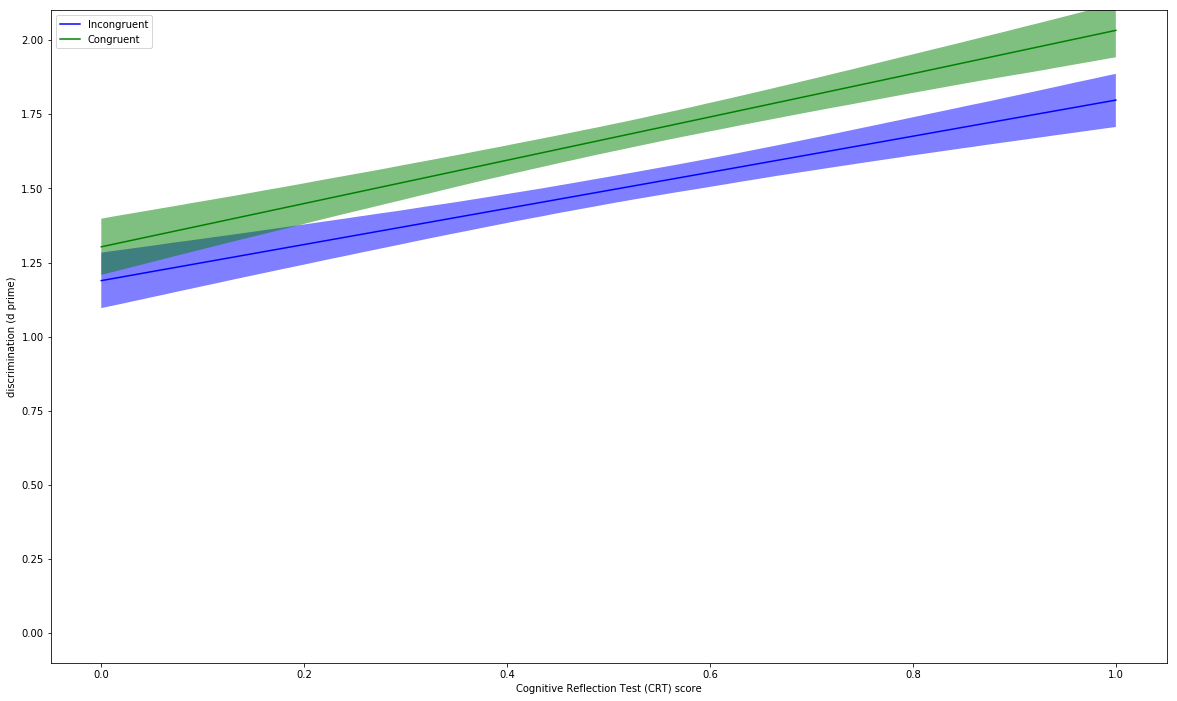

In [25]:
f = lambda x, *p: np.polyval(p, x) #our underlying model
plt.clf()

for cond,condlabel,colour in zip(['dprimeI','dprimeC'],['Incongruent','Congruent'],['blue','green']):

    x = df2['CRT_ACC']
    y = df2[cond]
    
    p, cov = curve_fit(f, x, y, [1, 1]) #first order fit = linear regression

    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000) #assume that the fit (p, cov) represents a normal distribution and sample from it
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0) # selecting the lower and upper 2.5% quantiles:
    upper = np.percentile(ysample, 97.5, axis=0)

    # regression estimate line
    y_fit = np.poly1d(p)(xi)
    # same as 
    # y_fit2 = xi*p[0]+p[1]
    # plot
    
    #plt.plot(x, y, 'bo') #don't plot individual points
    plt.plot(xi, y_fit, '-',color=colour,label=condlabel)
    plt.fill_between(xi, lower, upper, facecolor=colour, alpha=0.5)


plt.legend(loc=2)
plt.ylim([0,3])
plt.xlabel('Cognitive Reflection Test (CRT) score')
plt.ylabel('discrimination (d prime)')

Regression models, developed by Mate Gyurkovics and run in R, confirm that their are main effects of CRT and bias in both Study 1 and Study 2. There is an interaction of CRT and bias in study 1, but no significant interaction of CRT and bias in Study 2*

\* Of course, the value of NHST in the context of an exploratory analysis is debatable

Code here https://github.com/tomstafford/pennycook2018/blob/master/mate_model.R



# Acknowledgements

This analysis only possible because the study authors made their raw data available. Responsibility for errors of analysis and intepretation remains mine alone. Thanks to Dan Kahan (Yale), Warren Pearce, Kate Domment, August Lindemere (Sheffield) for discussion. Mate Gyurkovics advised on running regressions with continuous and factorial predictors and wrote the R code to do this.